<h1><b>MNist Handwritten Digit Classification</b></h1>

<h2>IMPORTING USEFUL LIBRARIES</h2>


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pltq1
!pip install keras-tuner
import kerastuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-2-0d99fcc6ac46>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner



<h2>LOADING MNIST DATASET</h2>


In [3]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


<h2>DATA PREPROCESSING</h2>


<h4>STANDARDISATION</h4>

In [4]:
# Standardization
X_train_standardized = (X_train - np.mean(X_train)) / np.std(X_train)
X_test_standardized = (X_test - np.mean(X_test)) / np.std(X_test)

# Add channel dimension
X_train_standardized = np.expand_dims(X_train_standardized, axis=-1)
X_test_standardized = np.expand_dims(X_test_standardized, axis=-1)


<h4>SPLITTING DATASET INTO TRAIN AND TEST SETS</h4>

In [5]:
# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_standardized, y_train, test_size=0.1, random_state=42)

<h3>DATA AUGMENTATION</h3>


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train_split)


<h2>SETTING MODEL ARCHITECTURE</h2>


<h3>MODEL BUILDER FUNCTION</h3>

In [7]:
# Define the model builder function
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28, 1)))

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    # Tune the dropout rate in the first Dropout layer
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout))

    model.add(keras.layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

<h3>DEFINING TUNER</h3>

In [8]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial
    directory='hyperparameter_tuning',
    project_name='mnist_hyperparameter_tuning'
)


<h3>HYPERPARAMETER TUNING</h3>


In [9]:
# Perform hyperparameter tuning
tuner.search(X_train_split, y_train_split,
             epochs=10,
             validation_data=(X_val_split, y_val_split))

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hp)

Trial 5 Complete [00h 02m 24s]
val_accuracy: 0.9818333387374878

Best val_accuracy So Far: 0.9818333387374878
Total elapsed time: 00h 10m 45s



<h2>TRAINING ON TRAIN SET</h2>


In [10]:
# Train the best model
history = best_model.fit(X_train_split, y_train_split,
                         epochs=10,
                         validation_data=(X_val_split, y_val_split))

Epoch 1/10
1688/1688 [==============================] - 15s 8ms/step - loss: 0.2777 - accuracy: 0.9139 - val_loss: 0.1343 - val_accuracy: 0.9587
Epoch 2/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1542 - accuracy: 0.9530 - val_loss: 0.0946 - val_accuracy: 0.9728
Epoch 3/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1299 - accuracy: 0.9592 - val_loss: 0.0968 - val_accuracy: 0.9723
Epoch 4/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1145 - accuracy: 0.9646 - val_loss: 0.0876 - val_accuracy: 0.9735
Epoch 5/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1019 - accuracy: 0.9691 - val_loss: 0.0799 - val_accuracy: 0.9760
Epoch 6/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0955 - accuracy: 0.9713 - val_loss: 0.0806 - val_accuracy: 0.9787
Epoch 7/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0870 - accuracy: 0.9727 - val_loss: 0.0813 - val_ac


<h2>EVALUATION ON TEST SET</h2>


In [11]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_standardized, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.0788 - accuracy: 0.9785
Test Loss: 0.07877079397439957
Test Accuracy: 0.9785000085830688



<h2>PLOTTING</h2>


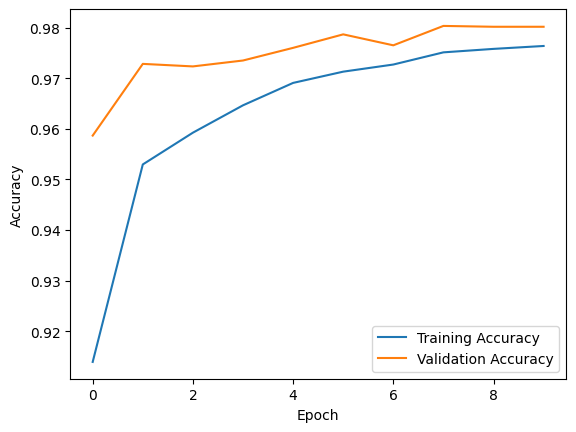

In [14]:
# Plot training and validation accuracy
pltq1.plot(history.history['accuracy'], label='Training Accuracy')
pltq1.plot(history.history['val_accuracy'], label='Validation Accuracy')
pltq1.xlabel('Epoch')
pltq1.ylabel('Accuracy')
pltq1.legend()
pltq1.show()